In [ ]:
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split



This method allows to resize the image and mask so the data is better suited to be used by the model. Only the RGB bands are kept for the image and the mask datais converted to binary.

In [ ]:
def preprocess_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    """Loads a Sentinel-2 image and its corresponding mask, resizes them, and normalizes values."""
    
    # Load the image from the input path
    with rasterio.open(image_path) as img_dataset:
        image = img_dataset.read()  
        rgb_image = np.stack([image[2], image[1], image[0]], axis=-1)  # Extract RGB bands

    
    # Resize the image
    rgb_image = cv2.resize(rgb_image, target_size)
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))


    # Load the corresponding mask
    with rasterio.open(mask_path) as mask_dataset:
        mask = mask_dataset.read(1)  # Read first band
    
    # Resize the mask and convert values to binary (Invert the mask so 1 = deforested, 0 = forest)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask - 1).astype(np.uint8)  # Convert 1 → 0 (Forest), 2 → 1 (Deforested)


    return rgb_image, mask

In [4]:
def preprocess_image_and_mask4(image_path, mask_path, target_size=(256, 256)):
    """Loads a Sentinel-2 image and its corresponding mask, resizes them, and normalizes values."""
    
    # Load the image from the input path
    with rasterio.open(image_path) as img_dataset:
        image = img_dataset.read()  
        nir_rgb_image = np.stack([image[3], image[2], image[1], image[0]], axis=-1)


    
    # Resize the image
    nir_rgb_image = cv2.resize(nir_rgb_image, target_size)
    nir_rgb_image = (nir_rgb_image - np.min(nir_rgb_image)) / (np.max(nir_rgb_image) - np.min(nir_rgb_image))


    # Load the corresponding mask
    with rasterio.open(mask_path) as mask_dataset:
        mask = mask_dataset.read(1)  # Read first band
    
    # Resize the mask and convert values to binary (Invert the mask so 1 = deforested, 0 = forest)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask - 1).astype(np.uint8)  # Convert 1 → 0 (Forest), 2 → 1 (Deforested)


    return nir_rgb_image, mask

This method ensures all the images and masks have been preprocessed beforecontinuing forward. The processed data is added to np.arrays that will be used from this point forward.

In [7]:
def preprocess_dataset():
    """Reads Sentinel-2 images & masks, applies preprocessing, and returns NumPy arrays."""
    
    images, masks = [], []
    target_size=(256, 256)
    image_folder = "dataset/deforestation-detection-dataset/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/"
    mask_folder = "dataset/deforestation-detection-dataset/3_TRAINING_MASKS/MASK_16_GRID/"
    
    # Get the list of all Sentinel-2 images
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".tif")]
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, img_file) 
        
        if not os.path.exists(mask_path):
            print(f"Skipping {img_file}: No matching mask found.")
            continue
        
        img, mask = preprocess_image_and_mask4(img_path, mask_path, target_size)
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


The test method ensure the testing hasn't caused any new issues.

In [ ]:
# PREPROCESSING METHODS TEST

def test_preprocessing():
    """Tests preprocess_dataset() by checking image and mask outputs."""
    
    X, y = preprocess_dataset()

    # Print the dataset details
    print(f"Dataset Loaded: {X.shape[0]} images, {y.shape[0]} masks")
    print(f"Image shape: {X.shape[1:]}, Mask shape: {y.shape[1:]}")

    # Check the normalization range for images
    print(f"Image Min-Max Values: {X.min()} - {X.max()}")  # Should be between 0 and 1

    # Check the unique values in masks (should be only [0,1])
    unique_values = np.unique(y)
    print(f"Unique Mask Values: {unique_values}")  

    # Assert that only 0 and 1 exist in masks
    assert set(unique_values).issubset({0, 1}), "Error: Mask contains unexpected values!"

    return X, y

# Run the test
X , y = test_preprocessing()


Dataset Loaded: 16 images, 16 masks
Image shape: (256, 256, 4), Mask shape: (256, 256)
Image Min-Max Values: 0.0 - 1.0
Unique Mask Values: [0 1]


In [9]:
def split_dataset(X, y, test_size=0.2, val_size=0.1, random_state=42):
    """Splits the dataset into training, validation, and testing sets."""

    # First, split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Further split training set into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_state
    )

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")
    print(f"Training masks: {y_train.shape}, Validation masks: {y_val.shape}, Testing masks: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Call function to split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, test_size=0.2, val_size=0.1)

Training set: (10, 256, 256, 4), Validation set: (2, 256, 256, 4), Testing set: (4, 256, 256, 4)
Training masks: (10, 256, 256), Validation masks: (2, 256, 256), Testing masks: (4, 256, 256)


This method converts the dataset in NumPy array to a tensorflow dataset, applies augmentation to the training data and batches it.

In [ ]:
def prepare_tf_dataset(X, y, batch_size=8):
    """Applies data augmentation and prepares dataset for training."""

    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Recreate datasets with augmentation
train_dataset = prepare_tf_dataset(X_train, y_train, batch_size=8)
val_dataset = prepare_tf_dataset(X_val, y_val, batch_size=8)
test_dataset = prepare_tf_dataset(X_test, y_test, batch_size=8)


print(train_dataset)
print(val_dataset)
print(test_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>


Model Latest version

Different loss function that were tried throughout model improvement iterations

In [ ]:
# Loss Functions
from keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dsc

# Dice + Binary Crossentropy Combo
def combined_loss(y_true, y_pred):
    # Dice Loss
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    dice_loss = 1 - dice
    
    # Binary Crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return 0.5 * dice_loss + 0.5 * bce  # Balanced combo


def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        return K.mean(bce * weight_vector)
    return loss

#loss_fn = weighted_binary_crossentropy(zero_weight=0.5, one_weight=1.0)

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt))
    return loss



Retired Model
It would guess predict the entire terrain to be deforested.

In [ ]:


def ASPP(inputs):
    """Atrous Spatial Pyramid Pooling (ASPP) module."""
    dims = inputs.shape[-1]

    pool = layers.GlobalAveragePooling2D()(inputs)
    pool = layers.Reshape((1, 1, dims))(pool)
    pool = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation="bilinear")(pool)

    conv_1x1 = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(inputs)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation("relu")(conv_1x1)

    conv_3x3_1 = layers.Conv2D(256, (3, 3), dilation_rate=6, padding="same", use_bias=False)(inputs)
    conv_3x3_1 = layers.BatchNormalization()(conv_3x3_1)
    conv_3x3_1 = layers.Activation("relu")(conv_3x3_1)

    conv_3x3_2 = layers.Conv2D(256, (3, 3), dilation_rate=12, padding="same", use_bias=False)(inputs)
    conv_3x3_2 = layers.BatchNormalization()(conv_3x3_2)
    conv_3x3_2 = layers.Activation("relu")(conv_3x3_2)

    conv_3x3_3 = layers.Conv2D(256, (3, 3), dilation_rate=18, padding="same", use_bias=False)(inputs)
    conv_3x3_3 = layers.BatchNormalization()(conv_3x3_3)
    conv_3x3_3 = layers.Activation("relu")(conv_3x3_3)

    x = layers.Concatenate()([pool, conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3])
    x = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

In [ ]:



# def build_model(hp):
#     """Builds a model with tunable hyperparameters."""
    
#     # Define tunable hyperparameters
#     learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])  # Tune LR
#     dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)  # Tune Dropout
    
#     # Load ResNet-50 as the backbone
#     base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
#     backbone = Model(inputs=base_model.input,outputs=base_model.get_layer("block_13_expand_relu").output)

#     # Apply ASPP (same as your original code)
#     aspp_output = ASPP(backbone.output)

#     # Final segmentation head
#     x = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(aspp_output)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)
#     x = layers.Dropout(dropout_rate)(x)  # Tunable dropout
#     x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x)
#     x = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

#     model = Model(inputs=backbone.input, outputs=x)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=dice_loss,
#         metrics=["accuracy"]
#     )

#     return model
# def build_model(hp):
#     input_shape = (256, 256, 3)

#     # Define tunable hyperparameters
#     learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])
#     dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

#     # Base MobileNetV2
#     base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
#     x = base_model.get_layer('block_13_expand_relu').output

#     # ASPP Module
#     x = ASPP(x)

#     # Segmentation head
#     x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
#     x = layers.Dropout(dropout_rate)(x)
#     x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x)
#     x = layers.Conv2D(1, 1, activation='sigmoid')(x)

#     model = tf.keras.Model(inputs=base_model.input, outputs=x)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=focal_loss,  # or dice_loss if preferred
#         metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
#     )

#     return model

def build_model(hp):
    input_shape = (256, 256, 3)

    # Hyperparameters to tune
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.0005, 0.001])
    dropout_rate = hp.Float("dropout", 0.2, 0.5, step=0.1)

    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights="imagenet")
    x = base_model.get_layer("block6a_expand_activation").output  # shallower features

    # ASPP module
    def ASPP(x):
        dims = x.shape[-1]
        y_pool = layers.GlobalAveragePooling2D()(x)
        y_pool = layers.Reshape((1, 1, dims))(y_pool)
        y_pool = layers.Conv2D(256, 1, padding="same", use_bias=False)(y_pool)
        y_pool = layers.BatchNormalization()(y_pool)
        y_pool = layers.Activation("relu")(y_pool)
        y_pool = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation="bilinear")(y_pool)

        y_1 = layers.Conv2D(256, 1, dilation_rate=1, padding="same", use_bias=False)(x)
        y_1 = layers.BatchNormalization()(y_1)
        y_1 = layers.Activation("relu")(y_1)

        y_6 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", use_bias=False)(x)
        y_6 = layers.BatchNormalization()(y_6)
        y_6 = layers.Activation("relu")(y_6)

        y_12 = layers.Conv2D(256, 3, dilation_rate=12, padding="same", use_bias=False)(x)
        y_12 = layers.BatchNormalization()(y_12)
        y_12 = layers.Activation("relu")(y_12)

        y_18 = layers.Conv2D(256, 3, dilation_rate=18, padding="same", use_bias=False)(x)
        y_18 = layers.BatchNormalization()(y_18)
        y_18 = layers.Activation("relu")(y_18)

        y = layers.Concatenate()([y_pool, y_1, y_6, y_12, y_18])
        y = layers.Conv2D(256, 1, padding="same", use_bias=False)(y)
        y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)
        return y

    x = ASPP(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x)
    x = layers.Conv2D(1, 1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=focal_loss,
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


# Define Keras Tuner search
tuner = kt.Hyperband(
    build_model, 
    objective="val_accuracy",
    max_epochs=10,
    factor=3, 
    directory="keras_tuner_results", 
    project_name="deforestation_segmentation"
)

# Run the search on the validation set
tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")

# Train final model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)


Reloading Tuner from keras_tuner_results/deforestation_segmentation/tuner0.json
Best Learning Rate: 0.001
Best Dropout Rate: 0.2
Epoch 1/20


TypeError: Expected float32, but got <function focal_loss.<locals>.loss at 0x32063a520> of type 'function'.

In [ ]:

def build_simple_cnn(input_shape=(256, 256, 4), dropout_rate=0.3, learning_rate=0.001):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)
    b = layers.Dropout(dropout_rate)(b)

    # Decoder
    u3 = layers.UpSampling2D((2, 2))(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

def build_model(hp):
    input_shape = (256, 256, 4)
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    return build_simple_cnn(input_shape=input_shape, dropout_rate=dropout_rate, learning_rate=learning_rate)


# Define Keras Tuner search
tuner = kt.Hyperband(
    build_model, 
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="keras_tuner_results",
    project_name="deforestation_cnn_simple"
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)



Reloading Tuner from keras_tuner_results/deforestation_cnn_simple/tuner0.json
Best Learning Rate: 0.0005
Best Dropout Rate: 0.2
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5365 - loss: 0.0432 - precision_1: 0.8566 - recall_1: 0.2168 - val_accuracy: 0.7313 - val_loss: 0.0418 - val_precision_1: 0.7295 - val_recall_1: 0.9970
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5937 - loss: 0.0424 - precision_1: 0.5898 - recall_1: 0.9974 - val_accuracy: 0.7210 - val_loss: 0.0401 - val_precision_1: 0.7210 - val_recall_1: 1.0000
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5989 - loss: 0.0418 - precision_1: 0.5989 - recall_1: 1.0000 - val_accuracy: 0.7210 - val_loss: 0.0386 - val_precision_1: 0.7210 - val_recall_1: 1.0000
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5990 - loss: 0.0409 - precision_1: 0.5989 - recall_1: 1.0000 - val_accuracy: 0.7405 - val_loss: 0.0385 - val_precision_1: 0.7354 - val_recall_1: 0.9998
Epoch 5/20
2/2 ━━━━

Train model until no longer necessary (as identified by early stopping)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  
    callbacks=[early_stopping]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8991 - loss: 0.0180 - precision_1: 0.9086 - recall_1: 0.9205 - val_accuracy: 0.9497 - val_loss: 0.0118 - val_precision_1: 0.9713 - val_recall_1: 0.9585
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9022 - loss: 0.0187 - precision_1: 0.9185 - recall_1: 0.9179 - val_accuracy: 0.9522 - val_loss: 0.0112 - val_precision_1: 0.9658 - val_recall_1: 0.9680
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9041 - loss: 0.0183 - precision_1: 0.9094 - recall_1: 0.9343 - val_accuracy: 0.9519 - val_loss: 0.0103 - val_precision_1: 0.9691 - val_recall_1: 0.9640
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8990 - loss: 0.0181 - precision_1: 0.9072 - recall_1: 0.9193 - val_accuracy: 0.9521 - val_loss: 0.0100 - val_precision_1: 0.9666 - val_recall_1: 0.9669
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8971 - loss: 0.0185 - precision_1: 0.8969 - recall_1: 0.9223 - val_accuracy: 0.9517 - v

In [20]:
# Saving a trained model
best_model.save("cnn_deforestation2.keras")
# Save the trained model weights
best_model.save_weights("trained_modelV5.weights.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


2025-03-30 20:33:13.352156: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


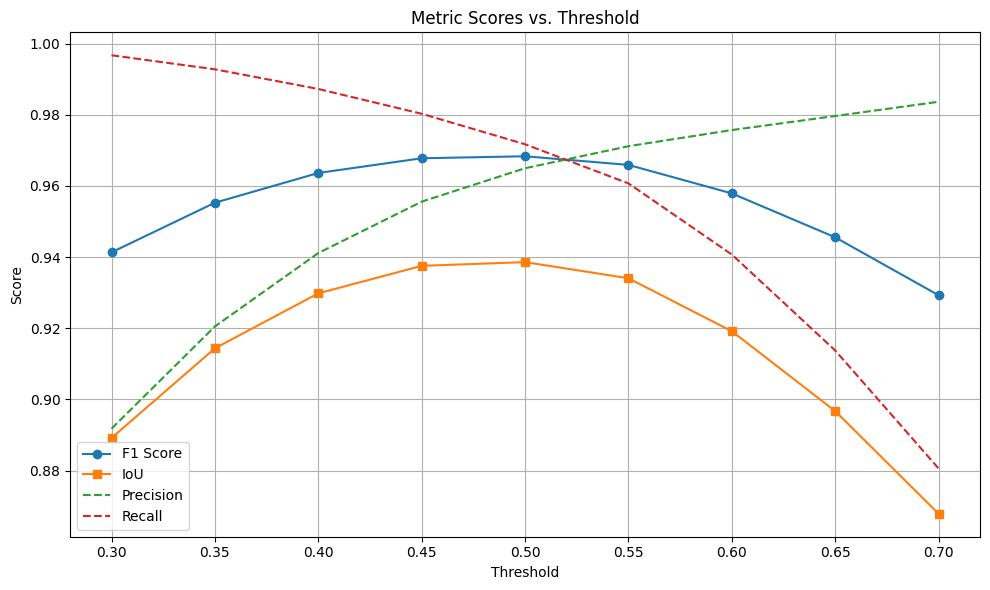

📊 Best threshold by F1 score: 0.50


In [ ]:
# Best Threshold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

all_preds = []
all_masks = []

for images, masks in val_dataset:
    preds = best_model.predict(images)
    all_preds.append(preds)
    all_masks.append(masks)


all_preds = np.concatenate(all_preds, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

y_true = all_masks.flatten().astype(np.uint8)

# Define threshold range
thresholds = np.arange(0.3, 0.71, 0.05)

f1s, ious, precisions, recalls = [], [], [], []

# Evaluate across thresholds
for t in thresholds:
    y_pred = (all_preds > t).astype(np.uint8).flatten()

    f1s.append(f1_score(y_true, y_pred))
    ious.append(jaccard_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

# Plot metrics vs thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.plot(thresholds, ious, label='IoU', marker='s')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Scores vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Get best threshold by F1
best_threshold = thresholds[np.argmax(f1s)]
print(f"Best threshold by F1 score: {best_threshold:.2f}")


Model Metrics & Validation

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Predict on test dataset
y_pred_probs = best_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype("int32") 

y_pred_flat = y_pred.flatten()
y_true_flat = np.concatenate([y.numpy().flatten() for _, y in test_dataset], axis=0)

# Compute metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print("Evaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
Evaluation Metrics:
Precision: 0.8475
Recall:    0.8799
F1 Score:  0.8634


2025-03-30 20:33:27.089910: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


2025-04-01 21:03:48.120688: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


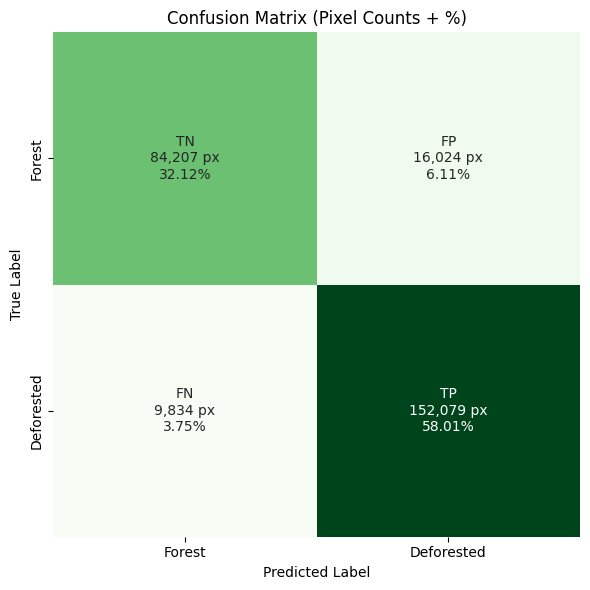

In [ ]:
# Confusion Matrix builder
import seaborn as sns

y_true_all = []
y_pred_all = []

THRESHOLD = 0.5

for images, masks in test_dataset:
    preds = best_model.predict(images)

    for i in range(images.shape[0]):
        true_mask = masks[i].numpy().squeeze().astype(np.uint8)
        pred_mask = preds[i].squeeze()
        binary_pred = (pred_mask > THRESHOLD).astype(np.uint8)

        y_true_all.extend(true_mask.flatten())
        y_pred_all.extend(binary_pred.flatten())

# Create confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100

labels = np.array([["TN", "FP"], ["FN", "TP"]])
counts = cm
percentages = cm_percent

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i, j]}\n{counts[i, j]:,} px\n{percentages[i, j]:.2f}%"

# Plot using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=annot, fmt="", cmap="Greens", cbar=False,
            xticklabels=["Forest", "Deforested"],
            yticklabels=["Forest", "Deforested"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Pixel Counts + %)")
plt.tight_layout()
plt.show()


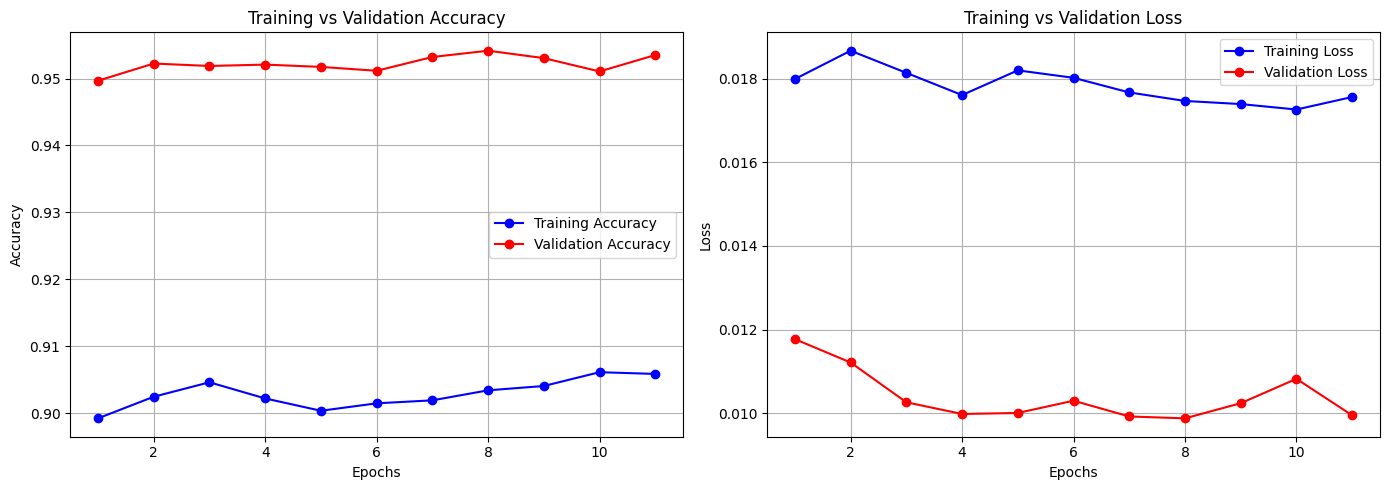

In [18]:
import matplotlib.pyplot as plt

# Extract history values dynamically
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].plot(epochs, acc, 'bo-', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss Plot
axes[1].plot(epochs, loss, 'bo-', label='Training Loss')
axes[1].plot(epochs, val_loss, 'ro-', label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


Visual Validation (Original image, Training Mask and Predicted Mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


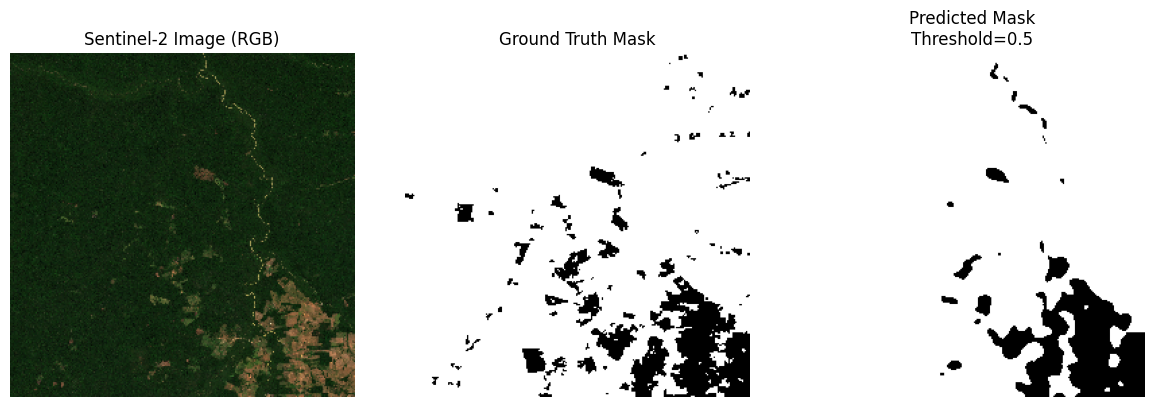

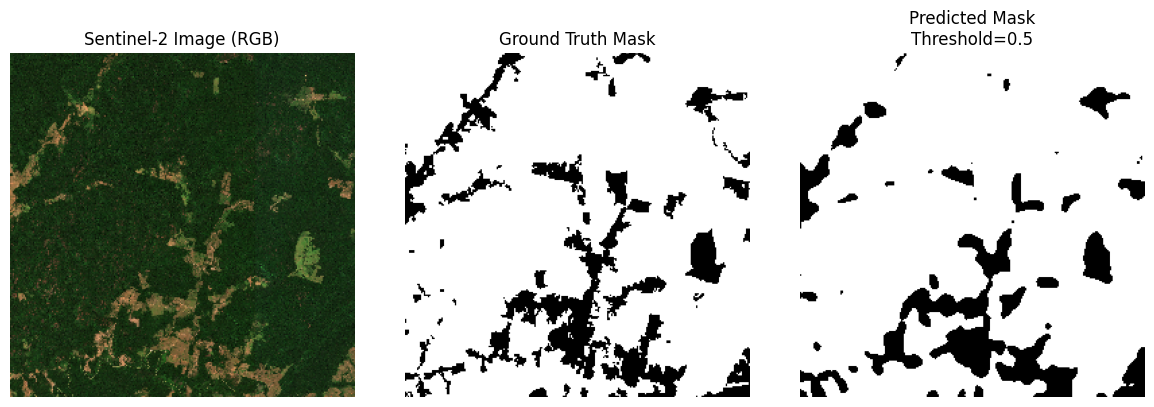

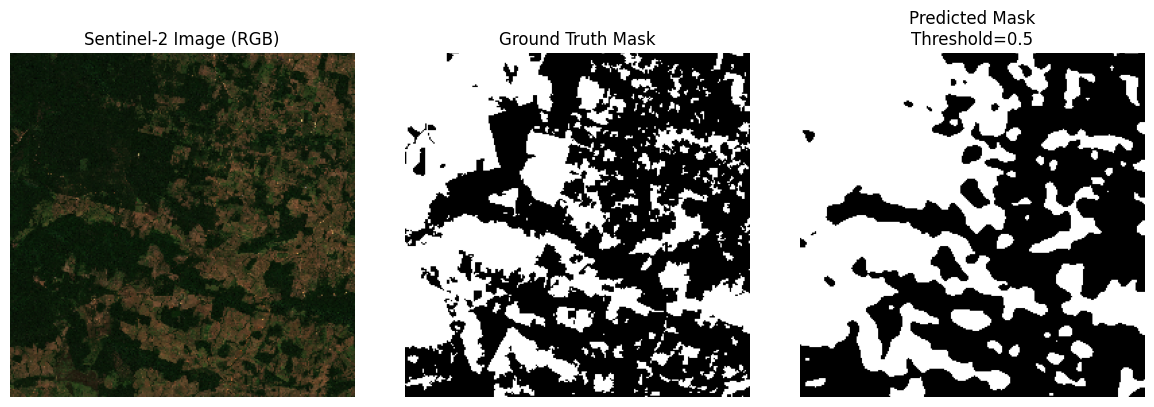

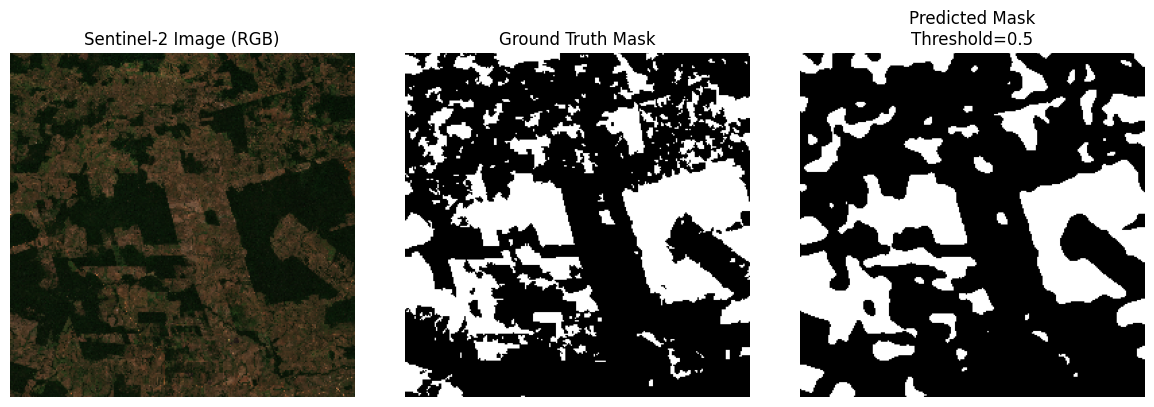

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

THRESHOLD = 0.50
N = 2

for i, (images, masks) in enumerate(test_dataset.take(N)):
    preds = best_model.predict(images)

    for j in range(images.shape[0]):
        image = images[j].numpy()
        true_mask = masks[j].numpy().squeeze()
        pred_mask = preds[j].squeeze()

        binary_pred = (pred_mask > THRESHOLD).astype(np.uint8)

        # Extract RGB 
        rgb_image = image[..., 1:4]
        # Normalize using min-max per image to make colors legit
        rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image) + 1e-8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_image)
        plt.title("Sentinel-2 Image (RGB)")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(binary_pred, cmap='gray')
        plt.title(f"Predicted Mask\nThreshold={THRESHOLD}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    if i >= N:
        break
